In [1]:
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import pipeline

c:\Users\ptrir\anaconda3\envs\gpu_py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('Clean_BA_reviews_v2.csv')
df.head()

,reviews,rating,clean_reviews,id
0,✅ Trip Verified | The entire booking and ticke...,1,entire book ticket experience stressful errone...,0
1,Not Verified | British Airways cancelled my ...,1,british airway cancel flight less 24 hour auto...,1
2,Not Verified | I wanted to write this review s...,10,want write review could give huge thank one st...,2
3,✅ Trip Verified | Check in fast and friendly....,7,check fast friendly security breeze lounge bus...,3
4,✅ Trip Verified | This is the first time I ha...,3,first time see new club world suite seat comfo...,4


### Word Cloud

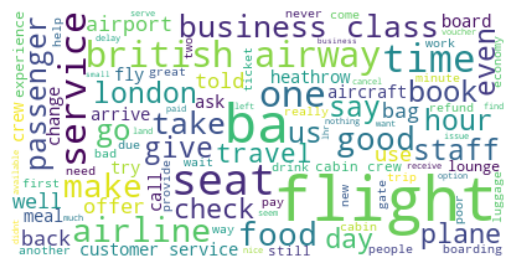

In [3]:
# Testing
text_cloud = ' '.join(df['clean_reviews'])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100,
                      background_color="white").generate(text_cloud)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Word Frequency

In [19]:
from collections import Counter

words = text_cloud.split()
word_freq = Counter(words)

(array([   0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(0.0, 0, '0'),
  Text(500.0, 0, '500'),
  Text(1000.0, 0, '1000'),
  Text(1500.0, 0, '1500'),
  Text(2000.0, 0, '2000'),
  Text(2500.0, 0, '2500')])

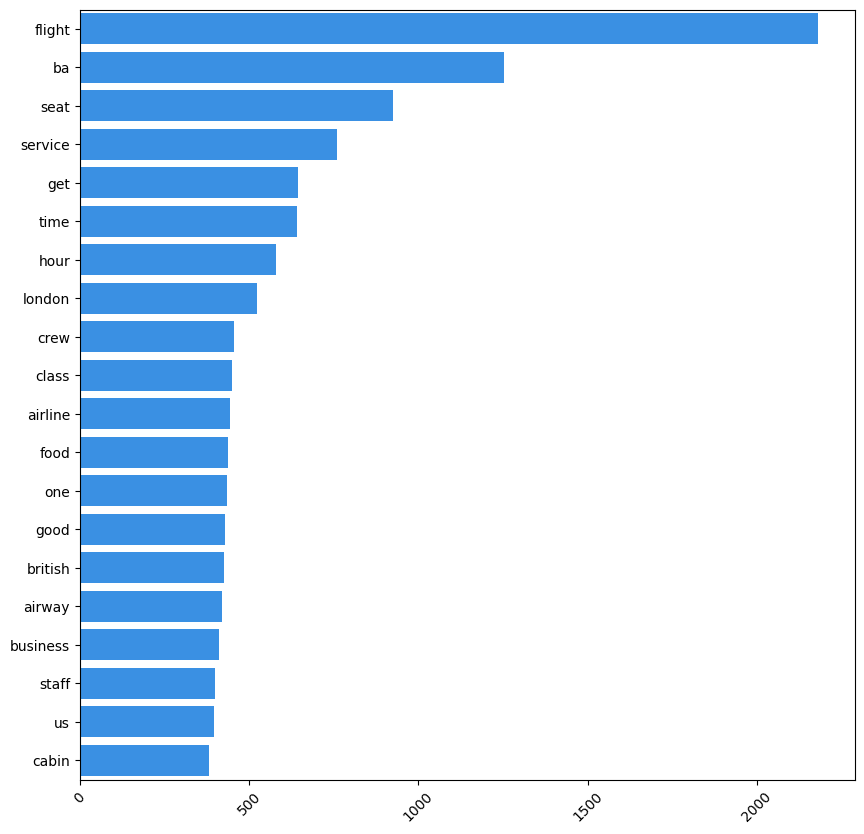

In [31]:
# Get the top 50 most frequent words
top_50_words = dict(word_freq.most_common(20))

plt.figure(figsize=(10,10))
sns.barplot( x=top_50_words.values(),y=top_50_words.keys(), color='dodgerblue')
plt.xticks(rotation=45)

In [ ]:
# Visualize the word frequencies (optional)
plt.figure(figsize=(10, 6))
plt.bar(word_freq.keys(), word_freq.values(), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency')
plt.xticks(rotation=45)
plt.show()

### Sentiment Analysis

In [4]:
from textblob import TextBlob

In [6]:
text_1 = df['clean_reviews'][0]
text_2 = df['clean_reviews'][1]

p_1 = TextBlob(text_1).sentiment.polarity
p_2 = TextBlob(text_2).sentiment.polarity

s_1 = TextBlob(text_1).sentiment.subjectivity
s_2 = TextBlob(text_2).sentiment.subjectivity

print("Polarity of Text 1 is", p_1)
print("Polarity of Text 2 is", p_2)
print("Subjectivity of Text 1 is", s_1)
print("Subjectivity of Text 2 is", s_2)

Polarity of Text 1 is 0.29551282051282046
Polarity of Text 2 is 0.01997245179063362
Subjectivity of Text 1 is 0.5897435897435896
Subjectivity of Text 2 is 0.4488980716253444


In [3]:
# Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
sentiments = []
for review in df['clean_reviews']:
    sentiment_scores = analyzer.polarity_scores(review)
    
    # Classify sentiment based on compound score
    if sentiment_scores['compound'] >= 0.05:
        sentiment_label = 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    # Store sentiment label
    sentiments.append({'Sentiment': sentiment_label})

df_sentiment_vader = pd.DataFrame(sentiments)

<Axes: xlabel='Sentiment', ylabel='Count'>

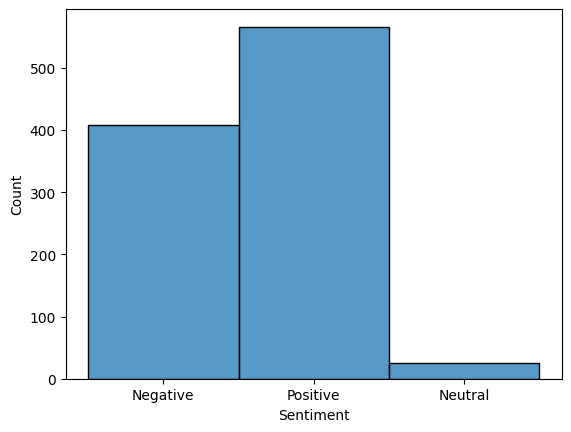

In [11]:
sns.histplot(data=df_sentiment_vader, x='Sentiment')

#### Transformer Model

In [16]:
## Distil Bert

classifier = pipeline("text-classification",model="distilbert-base-uncased-finetuned-sst-2-english")

batch_size = 32

sentiments = []
for i in range(0, 1000, batch_size):
    batch_reviews = df['clean_reviews'].iloc[i:i+batch_size].to_list()
    batch_results = classifier(batch_reviews)
    for result, review in zip(batch_results, batch_reviews):
        sentiments.append({'Review': review, 'Sentiment': result['label']})
        
df_sentiments = pd.DataFrame(sentiments)
df_sentiments['rating'] = df['rating']

In [23]:
## Bert Multilingual

classifier = pipeline("text-classification",
                      model="nlptown/bert-base-multilingual-uncased-sentiment")

batch_size = 32

sentiments = []
for i in range(0, 1000, batch_size):
    batch_reviews = df['clean_reviews'].iloc[i:i+batch_size].to_list()
    batch_results = classifier(batch_reviews)
    for result, review in zip(batch_results, batch_reviews):
        sentiments.append({'Review': review, 'Sentiment': result['label']})

df_sentiments = pd.DataFrame(sentiments)
df_sentiments['rating'] = df['rating']

In [24]:
df_sentiments.head(10)

,Review,Sentiment,rating
0,entire book ticket experience stressful errone...,1 star,1
1,british airway cancel flight less 24 hour auto...,1 star,1
2,want write review could give huge thank one st...,1 star,10
3,check fast friendly security breeze lounge bus...,4 stars,7
4,first time see new club world suite seat comfo...,2 stars,3
5,flew business class doha london 31st march ser...,1 star,4
6,start heathrow terminal 3 check fairly easy fa...,3 stars,8
7,flown route easyjet regularly twenty year age ...,1 star,1
8,last minute business trip hnd route regularly ...,3 stars,8
9,overall would say disappoint due ba status lou...,2 stars,5


#### Analysis

In [60]:
df_sent = pd.read_csv('sentiment_result_vDistilbert.csv', index_col=0)
df_sent.head()

,Review,Sentiment,rating
0,entire book ticket experience stressful errone...,NEGATIVE,1
1,british airway cancel flight less 24 hour auto...,NEGATIVE,1
2,want write review could give huge thank one st...,NEGATIVE,10
3,check fast friendly security breeze lounge bus...,POSITIVE,7
4,first time see new club world suite seat comfo...,NEGATIVE,3


<Axes: xlabel='Sentiment', ylabel='rating'>

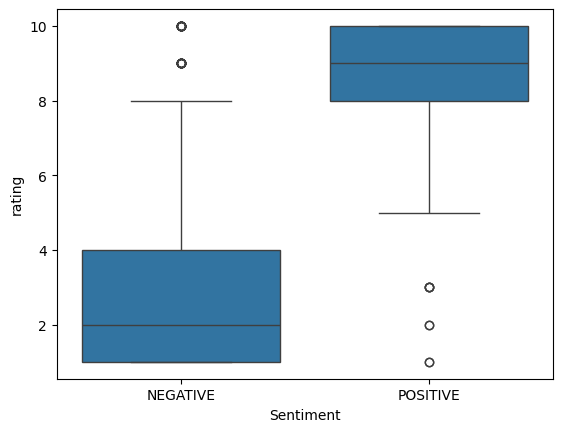

In [61]:
sns.boxplot(data=df_sent, x='Sentiment', y='rating')

<Axes: xlabel='rating', ylabel='Count'>

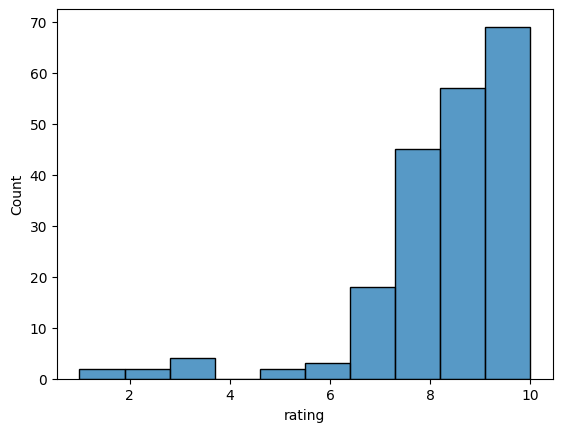

In [63]:
sent_positive = df_sent[df_sent['Sentiment'] == 'POSITIVE']

sns.histplot(data=sent_positive, x='rating', bins=10)

<Axes: xlabel='rating', ylabel='Count'>

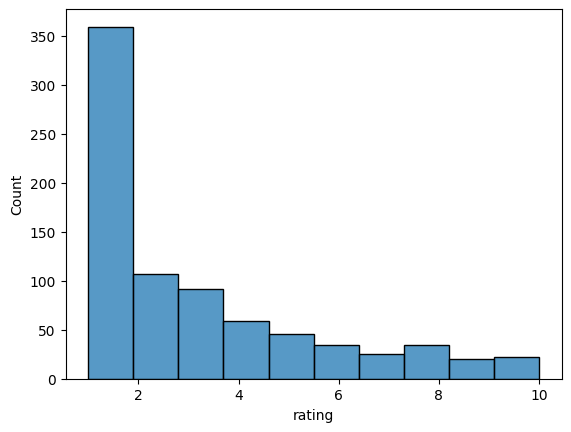

In [64]:
sent_negative = df_sent[df_sent['Sentiment']=='NEGATIVE']
sns.histplot(data=sent_negative, x='rating', bins=10)

In [5]:
df_sentiment_vader = pd.read_csv('sentiment_result_vVader.csv', index_col=0)
df_sentiment_vader.head()

,Sentiment
0,Negative
1,Negative
2,Positive
3,Positive
4,Positive


Text(0.5, 1.0, 'BA Reviews Sentiment')

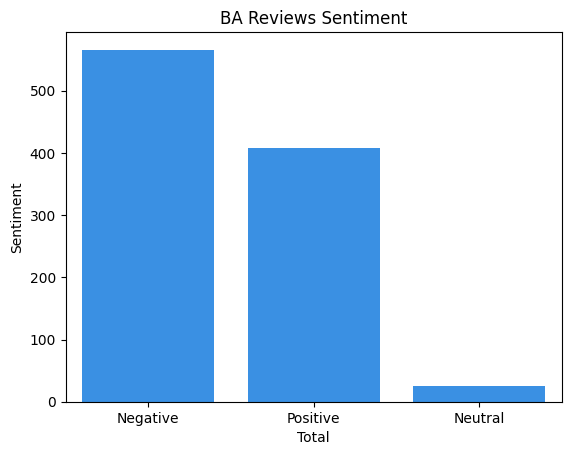

In [17]:
sns.barplot(x=df_sentiment_vader['Sentiment'].unique(
), y=df_sentiment_vader['Sentiment'].value_counts(), color='dodgerblue', legend=False)
plt.xlabel('Total')
plt.ylabel('Sentiment')
plt.title('BA Reviews Sentiment')